# COVID-19 Mortality Rate Between Countries With Low and High Smoking Rate
By: _Ray Nguyen, Jeffrey Song, Asar Zuluev_


## Introduction
At the end of 2019, the world witnessed a horrible news about the advent of a newly found yet deadly disease, Coronavirus disease (COVID-19). COVID-19  is a contagious disease that is caused by SARS-CoV-2, the severe acute respiratory syndrome coronavirus2. The first case was found in Wuhan, China, and quickly spread throughout the globe, leading to the COVID-19 pandemic. Common symtomps of COVID-19 vary, but usually include cough, fever, breathing difficulties, taste loss, smell loss. Many cases experienced critical symtomps like respiratory failure, multiorgan dysfunction, and ultimately decease. Several vaccines have been timely developed to contain the spread of this disease worldwide. Today we will look into the  situation of smoking rates and COVID-19 in several countries around the world. We will try to answer the question that does countries with high smoking rates have higher mortality rate of COVID-19 than countries with low smoking rates? We will look in to the mean of the death rate as our location parameter and the standard deviation of the death rate as our scale parameter.


## Preliminary Result

Now we take a look of the dataset. This dataset contains information about the COVID-19 pandemic that is updated daily by Our World in Data. It can be found under [this URL](https://github.com/owid/covid-19-data/tree/master/public/data). COVID-19 data recorded several aspects about the pandemic such as Confirmed cases, Confirm deaths, Hospital & ICU, Policy Responses, Vaccinations, etc. In this case, we will only examine:
- location: Countries.
- male_smokers: proportion of male smokers, most recent year possible.
- female_smokers: proportion of female smokers, most recent year possible.
- new_deaths: new deaths attributed to COVID-19 (within 7 days).
- new_cases : new confirmed cases attributed of COVID-19 (within 7 days).

With these information, we will transform the data to fit our objective of analysing the mortality rate and smoking rate.

First, we install libraries that are essential in implementing analysis and hypothesis testing.

In [17]:
library(tidyverse)
library(infer)
library(broom)
library(ggplot2)

Next, we will use read.csv() to read the dataset owid-covid-data, and use head() to visualize what it looks like. We recognise many observations in "new_deaths" and "new_cases" columns with NA value. Also, the dataset will be filtered by Europe, America, and Oceania only since Asia has some errors. To simplify the process, we will transform NAs into 0, which indicates there were no new cases or deaths recorded on that day. Then, we tidy the data by sorting out all the NAs value in "male_smokers" and "female_smokers" columns, and grouped them by location. Since we are interested in the smoking rate of a country as a whole, we create a new column of smokers by taking the average of male smoker and female smokers. Consequently, we summarise the dataset by adding the mean smokers and mortality rate columns.

In [4]:
data <- read.csv("https://raw.githubusercontent.com/RayNguyent/STAT-201-Project/main/data/owid-covid-data.csv")
data["new_cases"][is.na(data["new_cases"])] <- 0
data["new_deaths"][is.na(data["new_deaths"])] <- 0
data_cleaned <- data %>% filter(!is.na(male_smokers)) %>% filter(!is.na(female_smokers)) %>% filter(continent %in% c("Europe", "America","Africa","Oceania")) %>%
        group_by(location) %>% 
        mutate(smokers = (male_smokers + female_smokers)/2) %>% group_by(location) %>% 
        summarise(mean_smokers = mean(smokers), mortality_rate = sum(new_deaths)/sum(new_cases))
head(data_cleaned)


location,mean_smokers,mortality_rate
<chr>,<dbl>,<dbl>
Albania,29.15,0.010794177
Algeria,15.55,0.025411492
Andorra,33.40,0.003380051
Australia,14.75,0.001467342
Austria,29.65,0.003889079
Belarus,28.30,0.007160699


We plot the distribution of mean smoking rate to determine the threshold to divide the countries into high and low smoking rate. As we observed from the graph that it is a little right-skewed, it is most reasonable to use the median as out cutoff. The median smoking rate is 23.3.

[1] 23.3

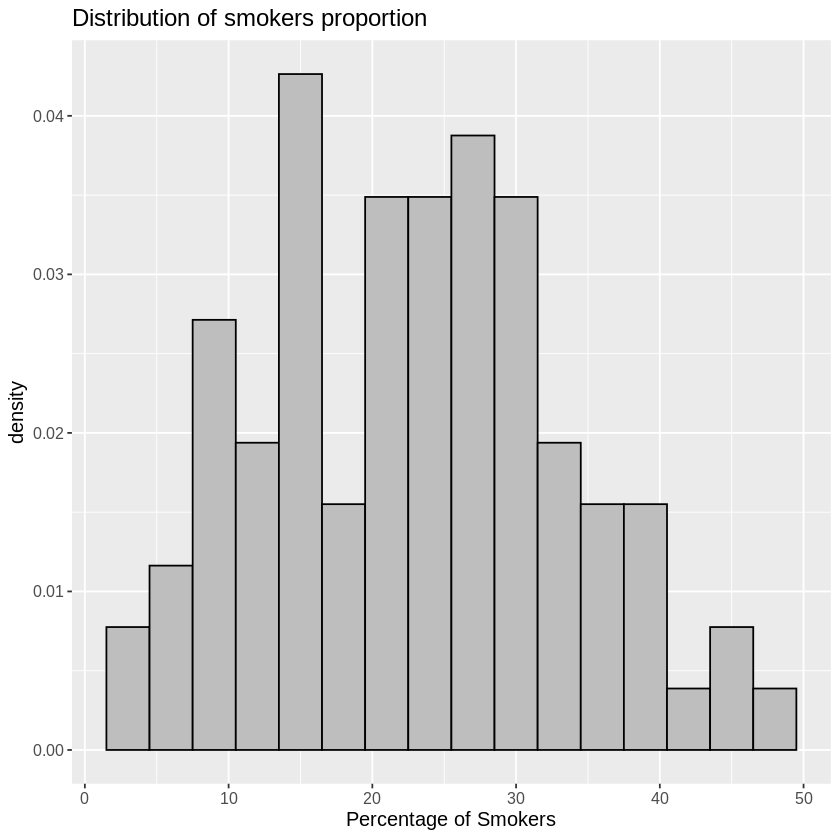

In [5]:
smokers_distri <- data_cleaned %>% ggplot(aes(x=mean_smokers, ..density..)) + geom_histogram(binwidth = 3, fill = "grey", color = "black") + labs(x = "Percentage of Smokers", title = "Distribution of smokers proportion") + 
        theme(text = element_text(size = 12))
smokers_distri
median(data_cleaned$mean_smokers)

To finalise our dataset, we create a new column indicates whether a country has high(> 23.3) or low smoking rate (<= 23.3). Only mortality rate and is_high_smoking_rate are kept in the final dataset.

In [7]:
data_final <- data_cleaned %>% mutate(is_high_smoking_rate = mean_smokers > 23.3) %>% select(-c(location, mean_smokers))
head(data_final) 

mortality_rate,is_high_smoking_rate
<dbl>,<lgl>
0.010794177,TRUE
0.025411492,FALSE
0.003380051,TRUE
0.001467342,FALSE
0.003889079,TRUE
0.007160699,TRUE


The next step is to divide the dataset into two parts corresponding to high or low smoking rate.

In [8]:
high_smoking_data <- data_final %>% filter(is_high_smoking_rate == "TRUE") %>% select(mortality_rate)
head(high_smoking_data)


low_smoking_data <- data_final %>% filter(is_high_smoking_rate == "FALSE") %>% select(mortality_rate)
head(low_smoking_data)

mortality_rate
<dbl>
0.010794177
0.003380051
0.003889079
0.007160699
0.007162074
0.040501623


mortality_rate
<dbl>
0.025411492
0.001467342
0.005823300
0.008549261
0.017890990
0.006586855


Next, we will calculate the mean mortality rate of countries with high smoking rate by using `summary`. The mean would be approximately 0.0118.

In [11]:
summary(high_smoking_data)

 mortality_rate     
 Min.   :0.0002169  
 1st Qu.:0.0042844  
 Median :0.0076505  
 Mean   :0.0117543  
 3rd Qu.:0.0174525  
 Max.   :0.0480912  

Likewise, we will calculate the mean mortality rate of countries with low smoking rate by using `summary`. The mean would be approximately 0.0132.

In [12]:
summary(low_smoking_data)

 mortality_rate     
 Min.   :0.0008769  
 1st Qu.:0.0051335  
 Median :0.0110668  
 Mean   :0.0132401  
 3rd Qu.:0.0213736  
 Max.   :0.0362337  

For the standard error, we will use `infer` package to make a bootstrap distribution of the mean mortality rate. Our standard error would be the spread of the bootstrap distribution's histogram. The standard error for mortality rate in high smoking rate countries is 0.0028.

In [37]:
set.seed(2022)
high_smoking_sample <- high_smoking_data %>% rep_sample_n(size = 20, reps = 1, replace = F)
high_smoking_bootstrap <- high_smoking_sample %>% specify(response = mortality_rate) %>%
                          generate(reps = 10000, type = "bootstrap") %>% 
                          calculate(stat = "mean")

high_smoking_se <- high_smoking_bootstrap %>% summarise(se = sd(stat))
high_smoking_data_vis <- high_smoking_bootstrap %>% ggplot(aes(x = stat)) + geom_histogram(, fill = "grey", color = "black") + 
                        labs(x = " Mortality Rate Means", title = "Bootstrap Distribution of Mortality Rate Means (high smoking rate)") + 
                        theme(text = element_text(size = 12))

By the same token, the estimated standard error of mortality rate of low smoking rate countries is 0.0024. And we will set the two plots side-by-side.

In [38]:
set.seed(2022)
low_smoking_sample<- low_smoking_data %>% rep_sample_n(size = 20, reps = 1, replace = F)
low_smoking_bootstrap <- low_smoking_sample %>% specify(response = mortality_rate) %>%
                          generate(reps = 10000, type = "bootstrap") %>% 
                          calculate(stat = "mean")
low_smoking_se <- low_smoking_bootstrap %>% summarise(se = sd(stat))

low_smoking_data_vis <- low_smoking_bootstrap %>% ggplot(aes(x = stat)) + geom_histogram(fill = "grey", color = "black") + 
                        labs(x = " Mortality Rate Means", title = "Bootstrap Distribution of Mortality Rate Means (low smoking rate)") + 
                        theme(text = element_text(size = 12))

Our final result is presented in the matrix below.

In [41]:
result <- data.frame(mean_highsmoking = mean(high_smoking_data$mortality_rate),
                 se_highsmoking = high_smoking_se,
                 mean_lowsmoking = mean(low_smoking_data$mortality_rate),
                 se_lowsmoking = low_smoking_se)
result

mean_highsmoking,se,mean_lowsmoking,se.1
<dbl>,<dbl>,<dbl>,<dbl>
0.01175432,0.002819303,0.01324007,0.00237919


Test......

In [45]:
test <- tidy(
    t.test(x = high_smoking_data$mortality_rate,
           y = low_smoking_data$mortality_rate,
           alternative = "two.sided")
    )
test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.00148575,0.01175432,0.01324007,-0.6851582,0.4951369,83.71631,-0.005798219,0.002826719,Welch Two Sample t-test,two.sided


## Method

The method that we are conducting this hypothesis test is based on a few good qualities that contribute to its reliability. First, the Covid-19 data set that we are testing upon represents a large sample of countries across the world and is representative of the larger population of Covid-19 infections. We are able to verify that the sampling distribution most adhears to a normal distribution which will allow us to use the central limit theorem as a tool in hypothesis testing. The individual data points contained in each country are pulled from quality sources such as national health authorities and the WHO. Further, there is a large body of research on the effects of smoking and potential mortality rates which we could use to further verify our conclusions. We have included two relevant papers in the reference section which will help us frame our findings.

While our preliminary visualizations showcase both the sampling and bootstrap distributions , it fails to explore the hypothesis using statistical tests at significant levels. We will target the accuracy of the estimates by making confidence intervals in the final report.

We intend to explore the hypothesis that the mortality rate of covid infections in high smoking cultures ($\bar{X1}$) is greater then non-smoking cultures ($\bar{X2}$) at a 95% confidence interval:

$H_0: \bar{X1} = \bar{X2}$

$H_1: \bar{X1} > \bar{X2}$

From previous papers, we expect to find that countries with high proportions of smokers will have a higher mortality rate.
However, we expect the test to be deficient in a few areas. First, since the dataset is the summation of nations instead of individual patients, we expect that the variables are not independent. There are other factors that could directly influence mortality rate such as health care standards, overall economic health and potentially education levels. 
This could lead to future research question on answer which variable is the most signifacant contributor to overall morality rate from Covid-19 infections.


## References
Hou H;Li Y;Zhang P;Wu J;Shi L;Xu J;Diao J;Wang Y;Yang H; (n.d.). Smoking is independently associated with an increased risk for covid-19 mortality: A systematic review and meta-analysis based on adjusted effect estimates. Nicotine &amp; tobacco research : official journal of the Society for Research on Nicotine and Tobacco. Retrieved November 5, 2022, from https://pubmed.ncbi.nlm.nih.gov/34049390/ 

Piasecki TM;Smith SS;Baker TB;Slutske WS;Adsit RT;Bolt DM;Conner KL;Bernstein SL;Eng OD;Lazuk D;Gonzalez A;Jorenby DE;D'Angelo H;Kirsch JA;Williams BS;Nolan MB;Hayes-Birchler T;Kent S;Kim H;Lubanski S;Yu M;Suk Y;Cai Y;Kashyap N;Mathew JP;McMahan G;Rolland. (n.d.). Smoking status, nicotine medication, vaccination, and covid-19 hospital outcomes: Findings from the COVID EHR cohort at the University of Wisconsin (CEC-UW) study. Nicotine &amp; tobacco research : official journal of the Society for Research on Nicotine and Tobacco. Retrieved November 5, 2022, from https://pubmed.ncbi.nlm.nih.gov/36069915/ 